### โมเดลจำแนกภาพดอกลิลลี่และดอกกล้วยไม้ ด้วยวิธี Deep Learning

นำเข้า library ที่จำเป็นและนำเข้าข้อมูลที่ใช้ในการทำนายผล

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image



ตั้งค่าพารามิเตอร์และทำการโหลดข้อมูล

In [2]:
batch_size = 32
img_height = 180
img_width = 180

data_dir = "D:\\AI\\Classification\\Flower"


In [3]:
# โหลดชุดข้อมูลจากโฟลเดอร์
dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 145 files belonging to 2 classes.


In [4]:
# เพิ่ม Data Augmentation เพื่อช่วยลด Overfitting
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),  # พลิกรูปในแนวนอนแบบสุ่ม
    layers.RandomRotation(0.3),  # หมุนรูปภาพแบบสุ่ม
    layers.RandomZoom(0.3),  # ซูมเข้า/ออกแบบสุ่ม
    layers.RandomContrast(0.3),  # ปรับความเปรียบต่างของภาพแบบสุ่ม
    layers.RandomBrightness(0.2),  # ปรับความสว่างของภาพแบบสุ่ม
])

In [5]:
# แบ่งชุดข้อมูลเป็น training และ validation
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size).map(lambda x, y: (data_augmentation(x), y))  # ใช้ Augmentation กับ Training Data
val_ds = dataset.skip(train_size)

# กำหนดจำนวนคลาส
num_classes = len(dataset.class_names)

In [6]:
# กำหนดป้ายกำกับของคลาส (เพื่อให้แน่ใจว่าตรงกับข้อมูลที่ใช้เทรน)
class_labels = ["lilies", "orchids"]  

In [7]:
# ใช้ Transfer Learning จาก MobileNetV2 เพื่อลดการฝึกจากศูนย์
base_model = keras.applications.MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

# ปลดล็อกบางชั้นของ Base Model เพื่อ Fine-tune
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30  # ปลดล็อก 30 ชั้นสุดท้าย

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False  # ล็อกชั้นที่อยู่ก่อน fine_tune_at

C:\Users\ASUS\AppData\Local\Temp\ipykernel_25076\924544823.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step - accuracy: 0.4615 - loss: 1.1159 - val_accuracy: 0.4118 - val_loss: 1.3306 - learning_rate: 3.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6396 - loss: 0.9984 - val_accuracy: 0.4118 - val_loss: 1.8447 - learning_rate: 3.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7521 - loss: 0.8091 - val_accuracy: 0.3529 - val_loss: 1.8531 - learning_rate: 3.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6687 - loss: 0.9695 - val_accuracy: 0.7059 - val_loss: 1.3589 - learning_rate: 3.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 994ms/step - accuracy: 0.7021 - loss: 0.9229 - val_accuracy: 0.6471 - val_loss: 1.2324 - learning_rate: 1.5000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7969 - loss: 0.7279 - val_accuracy: 0.9412 - val_loss: 0.5138 - learning_rate: 1.5000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7333 - loss: 0.7944 - val_acc

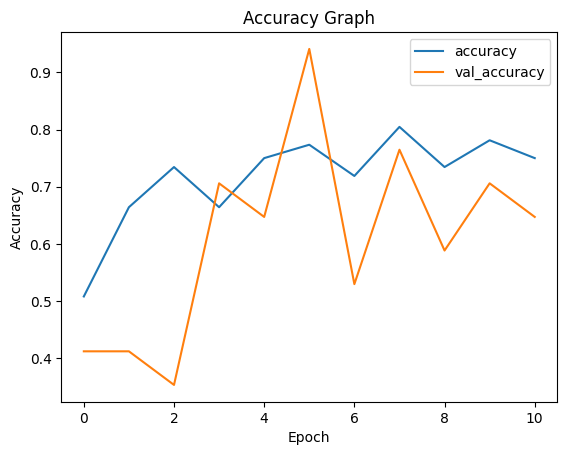

In [8]:
# ปรับแต่งโมเดล CNN
model = keras.Sequential([
    layers.Input(shape=(180, 180, 3)),
    data_augmentation,  # ใช้เทคนิคเพิ่มความหลากหลายของข้อมูล
    base_model,  # ใช้โมเดลฐาน
    layers.GlobalAveragePooling2D(),  # ลดขนาดข้อมูลให้เหลือเพียงค่าเฉลี่ยของฟีเจอร์แมพ
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),  # ชั้น Dense พร้อม Regularization
    layers.Dropout(0.4),  # ลด Overfitting ด้วย Dropout
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    layers.Dropout(0.4),
    layers.Dense(len(class_labels), activation='softmax')  # ชั้นสุดท้ายใช้ Softmax เพื่อจำแนกประเภท
])

# ปรับ Learning Rate ให้เหมาะสมขึ้น
optimizer = keras.optimizers.Adam(learning_rate=0.0003)

# คอมไพล์โมเดล
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # ฟังก์ชัน Loss สำหรับปัญหาจำแนกประเภท
              metrics=['accuracy'])
 
# ใช้ Early Stopping และ ReduceLROnPlateau
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# ฝึกโมเดล
epochs = 30
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, reduce_lr])

# แสดงผลลัพธ์ความแม่นยำ
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show()

ทดลองโมเดล

In [9]:
# ฟังก์ชันสำหรับทำนายภาพแต่ละรูป
def predict_flower(model, image_path):
    test_image = image.load_img(image_path, target_size=(180, 180))  # โหลดภาพและปรับขนาด
    test_image = image.img_to_array(test_image)  # แปลงภาพเป็นอาเรย์
    test_image = np.expand_dims(test_image, axis=0)  # ขยายมิติให้ตรงกับอินพุตของโมเดล
    test_image /= 255.0  # ปรับค่าพิกเซลให้อยู่ในช่วง 0-1
    
    result = model.predict(test_image)  # ทำการทำนาย
    predicted_class = np.argmax(result)  # เลือกคลาสที่มีค่าสูงสุด
    return class_labels[predicted_class]  # คืนค่าชื่อคลาสที่ทำนายได้

# เลือกสุ่ม 50 รูปจากแต่ละประเภท
lily_images = random.sample(os.listdir('Flower/lilies'), 50)
orchid_images = random.sample(os.listdir('Flower/orchids'), 50)

# ทดสอบโมเดลกับภาพ 100 รูป
correct_predictions = 0
total_images = len(lily_images) + len(orchid_images)

print("\nเริ่มทดสอบโมเดลกับภาพ 100 รูป\n")
for i, img_name in enumerate(lily_images + orchid_images):
    category = 'lilies' if i < 50 else 'orchids'  # กำหนดป้ายกำกับที่ถูกต้องของแต่ละรูป
    image_path = f'Flower/{category}/{img_name}'  # ระบุพาธของรูป
    prediction = predict_flower(model, image_path)  # ทำนายรูปภาพ
    actual_label = category  # กำหนดป้ายกำกับจริง
    
    if prediction == actual_label:
        correct_predictions += 1  # นับจำนวนที่ทำนายถูกต้อง
    
    print(f'รูปที่ {i+1}: ทำนาย = {prediction}, ค่าจริง = {actual_label}')

# คำนวณความแม่นยำของโมเดลในการทดสอบ
accuracy = (correct_predictions / total_images) * 100
print("\nสรุปผลการทดสอบ\n")
print(f"โมเดลทำนายถูกต้อง {correct_predictions} จากทั้งหมด {total_images} ภาพ")


เริ่มทดสอบโมเดลกับภาพ 100 รูป

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
รูปที่ 1: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
รูปที่ 2: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
รูปที่ 3: ทำนาย = lilies, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
รูปที่ 4: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
รูปที่ 5: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
รูปที่ 6: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
รูปที่ 7: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
รูปที่ 8: ทำนาย = orchids, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
รูปที่ 9: ทำนาย = lilies, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
รูปที่ 10: ทำนาย = lilies, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
รูปที่ 11: ทำนาย = lilies, ค่าจริง = lilies
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
รูปที่ 12: ทำนาย = orchids, ค